## Libraries

In [108]:
import pandas as pd
import csv
import nltk
import re
import numpy as np
from nltk.stem import WordNetLemmatizer
wordnet_lemmatizer = WordNetLemmatizer()
from sklearn.feature_extraction.text import TfidfVectorizer,CountVectorizer
from sklearn import model_selection
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
import warnings
warnings.filterwarnings('ignore')
import matplotlib.pyplot as plt
from sklearn.metrics import accuracy_score,f1_score


## Preprocessing

In [93]:
def read_files_utf8(path):
    file = open(path, encoding="utf8")
    with file:
        reader = csv.reader(file, delimiter="\t")
        data = list(reader)
    return data

def append_data(data):
    list_data = []
    for item in data:
        list_data.append((item[0],item[1]))
    return list_data

def get_tweets(data):
    tweets = []
    for item in data:
        tweets.append(item[1])
    return tweets

def remove_punctuation(sentence):
    new_sentence_tokens = []
    for token in sentence:
        new_token = re.sub(r'[^\w\s]', '', token)
        if new_token != '':
            new_sentence_tokens.append(new_token)
    return new_sentence_tokens

def remove_URL(item):
    return re.sub(r"http\S+", "", item)

def preprocess_data(data):
    lemmatizer = WordNetLemmatizer()
    tokenized_data = []
    for item in data:
        item = remove_URL(item)
        tokens = nltk.word_tokenize(item.lower())
        tokens = remove_punctuation(tokens)
        lemmatized_output = ' '.join([lemmatizer.lemmatize(token) for token in tokens])
        tokenized_data.append(lemmatized_output)
    return tokenized_data

# There are some empty tweets with garbage I needed to remove to match the number of tweets with labels
def remove_unnecessary_tweets(tweets, labels):
    clean_labels = []
    tweets_ids = [i[0] for i in tweets]
    for label in labels:
        if label[0] in tweets_ids:
            clean_labels.append(label[1])
    return clean_labels

# Getting training data
path = 'train-tweets.txt'
train_data = read_files_utf8(path)
path = 'train-labels.txt'
train_labels = read_files_utf8(path)

# Getting development data
path = 'eval-tweets.txt'
eval_data = read_files_utf8(path)
path = 'eval-labels.txt'
eval_labels = read_files_utf8(path)

# Getting testing data
path = 'test-tweets.txt'
test_data = read_files_utf8(path)


train_tweets = append_data(train_data)
train_labels = append_data(train_labels)
train_labels = remove_unnecessary_tweets(train_tweets, train_labels)
train_tweets = get_tweets(train_tweets)

eval_tweets = append_data(eval_data)
eval_labels = append_data(eval_labels)
eval_labels = remove_unnecessary_tweets(eval_tweets, eval_labels)
eval_tweets = get_tweets(eval_tweets)

test_tweets = append_data(test_data)
test_tweets = get_tweets(test_tweets)

train_tweets = preprocess_data(train_tweets)
eval_tweets = preprocess_data(eval_tweets)
test_tweets = preprocess_data(test_tweets)

In [94]:
def algorithm_comparison(X ,y):
    print("="*100)
    print('Algorithms Comparison')
    print("="*100)
    seed = 7
    models = []
    models.append(('LR', LogisticRegression()))
    models.append(('KNN', KNeighborsClassifier()))
    models.append(('DT', DecisionTreeClassifier()))
    models.append(('RF', RandomForestClassifier()))
    models.append(('NB', MultinomialNB()))
    models.append(('SVM', SVC()))
    values = []
    names = []
    scoring = 'accuracy'
    for name, model in models:
        kfold = model_selection.KFold(n_splits=10, random_state=seed)
        cv_results = model_selection.cross_val_score(model, X, y, cv=kfold, scoring=scoring)
        values.append(cv_results.mean())
        names.append(name)
        results = "%s: %f (%f)" % (name, cv_results.mean(), cv_results.std())
        print(results)
   
    plt.figure(figsize=(20, 5))
    plt.subplot(131)
    plt.bar(names, values)
    plt.subplot(133)
    plt.plot(names, values)
    plt.suptitle('Accuracy Comparison')
    plt.show()

## Modeling selection with word counts

Algorithms Comparison
LR: 0.594429 (0.013086)
KNN: 0.449328 (0.035867)
DT: 0.518516 (0.021513)
RF: 0.591158 (0.016749)
NB: 0.588731 (0.011908)
SVM: 0.583435 (0.012309)


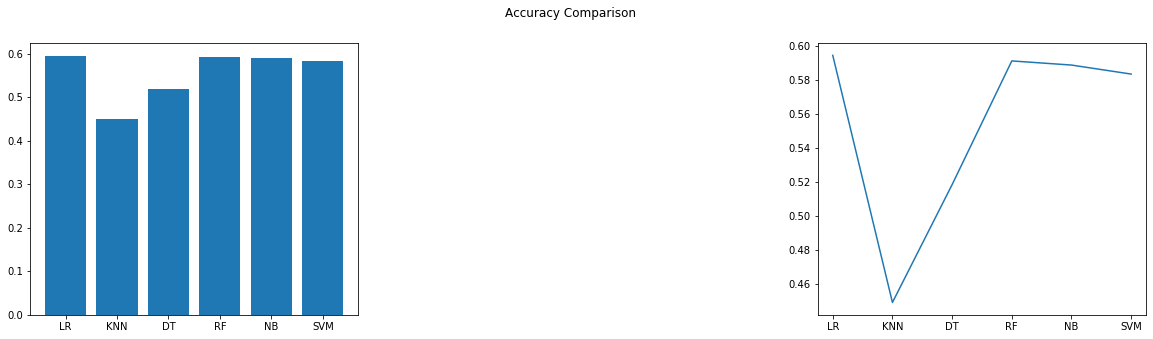

In [99]:
vectorizer = CountVectorizer()
vector_eval = vectorizer.fit_transform(eval_tweets)
algorithm_comparison(vector_eval, eval_labels)

## Modeling selection with word frequencies

Algorithms Comparison
LR: 0.598091 (0.013636)
KNN: 0.546610 (0.023662)
DT: 0.508948 (0.017107)
RF: 0.581598 (0.012484)
NB: 0.550064 (0.012799)
SVM: 0.584046 (0.012314)


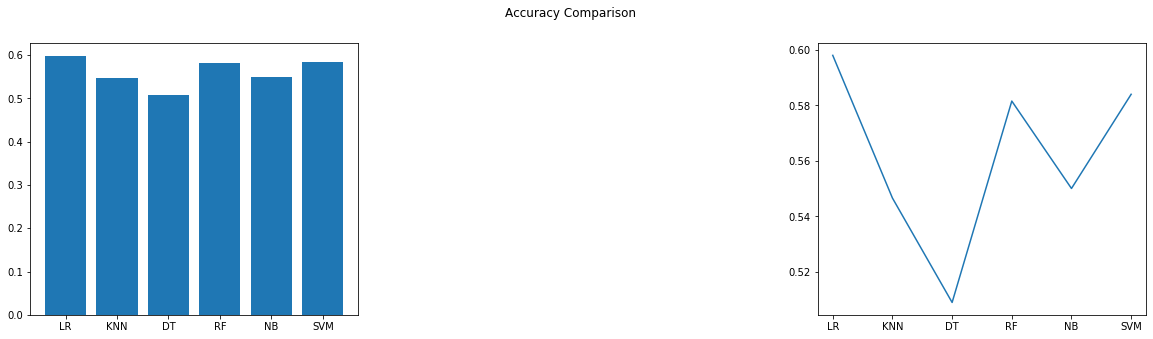

In [102]:
vectorizer = TfidfVectorizer()
vector_eval = vectorizer.fit_transform(eval_tweets)
algorithm_comparison(vector_eval, eval_labels)

## Training Model

In [121]:
#Using best model for this task and tuning it

vectorizer = TfidfVectorizer()
vector_train = vectorizer.fit_transform(train_tweets)
vector_eval = vectorizer.transform(eval_tweets)
vector_test = vectorizer.transform(test_tweets)

# Training and scoring for training set
clf = LogisticRegression()
parameters = {"C":np.logspace(-3,3,7), "penalty":["l1","l2"]}
clf_grid = GridSearchCV(clf, parameters)
clf_grid.fit(vector_eval,eval_labels )
y_pred = clf_grid.predict(vector_eval)
print("Best Parameters: ",clf_grid.best_params_)
print("Best Score: ",clf_grid.best_score_)
print('Eval accuracy: ',accuracy_score(eval_labels, y_pred))

clf = LogisticRegression()
clf.set_params(**clf_grid.best_params_)
clf.fit(vector_train, train_labels)
y_pred = clf.predict(vector_train)
print('Train accuracy: ',accuracy_score(train_labels, y_pred))

# Predicting for test set ...
y_test_pred = clf.predict(vector_test)

Best Parameters:  {'C': 1.0, 'penalty': 'l2'}
Best Score:  0.6039875438462
Eval accuracy:  0.8247863247863247
Train accuracy:  0.8031379385487034
